In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam 
import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

In [21]:
data=pd.read_csv('/kaggle/input/stock-price/stock_price_translated.csv')

In [22]:
data.head()

,Date,Close,Open,High,Low,Volume,Change %
0,2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
4,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%


In [23]:
data.shape

(9202, 7)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      9202 non-null   object 
 1   Close     9202 non-null   float64
 2   Open      9202 non-null   float64
 3   High      9202 non-null   float64
 4   Low       9202 non-null   float64
 5   Volume    9202 non-null   object 
 6   Change %  9202 non-null   object 
dtypes: float64(4), object(3)
memory usage: 503.4+ KB


In [25]:
data.describe()

,Close,Open,High,Low
count,9202.000000,9202.000000,9202.000000,9202.000000
mean,92.180961,92.256183,93.176451,91.330146
std,50.452228,50.598215,51.049837,50.087405
min,33.000000,33.000000,33.200000,32.200000
25%,52.000000,52.100000,52.800000,51.500000
50%,85.100000,85.100000,86.050000,84.200000
75%,110.800000,110.800000,111.900000,109.275000
max,305.900000,309.800000,311.800000,303.900000


In [26]:
data.isnull().sum()

Date        0
Close       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64

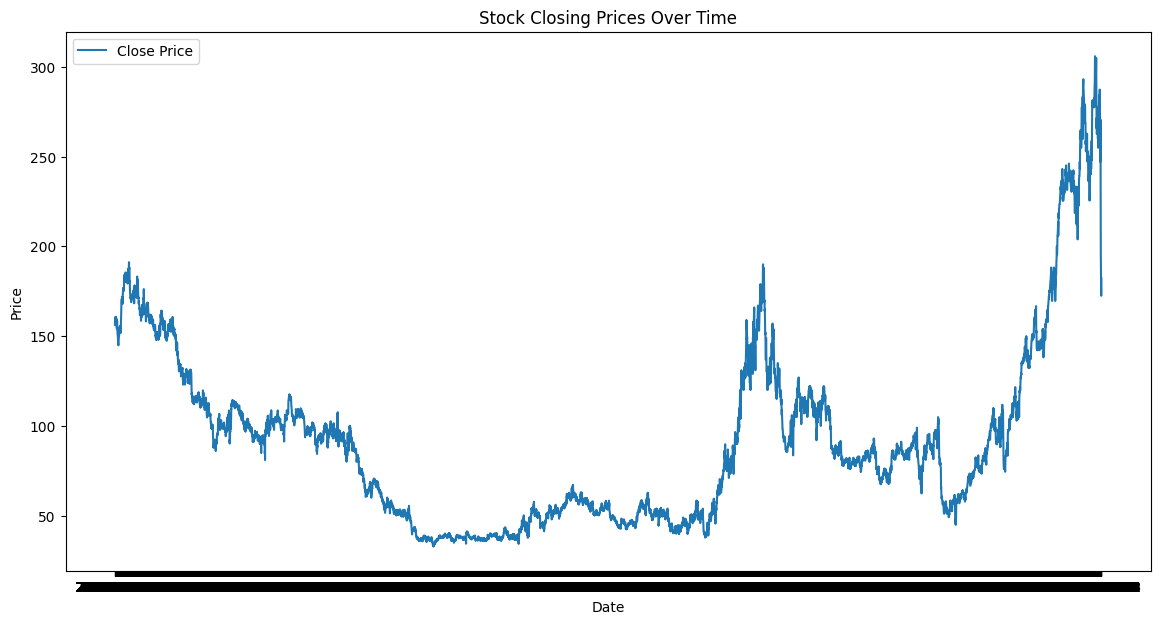

In [27]:
# Plotting the closing prices over time
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


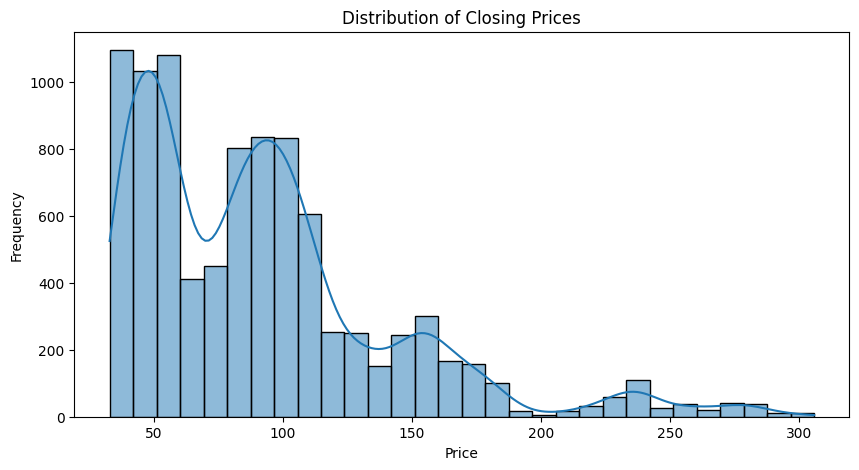

In [28]:
# Distribution of the Close price
plt.figure(figsize=(10, 5))
sns.histplot(data['Close'], bins=30, kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

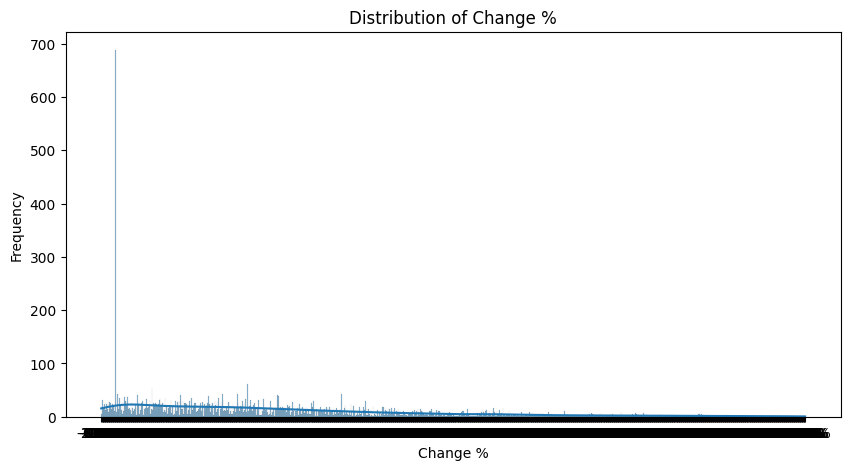

In [29]:
# Distribution of Change %
plt.figure(figsize=(10, 5))
sns.histplot(data['Change %'], bins=30, kde=True)
plt.title('Distribution of Change %')
plt.xlabel('Change %')
plt.ylabel('Frequency')
plt.show()

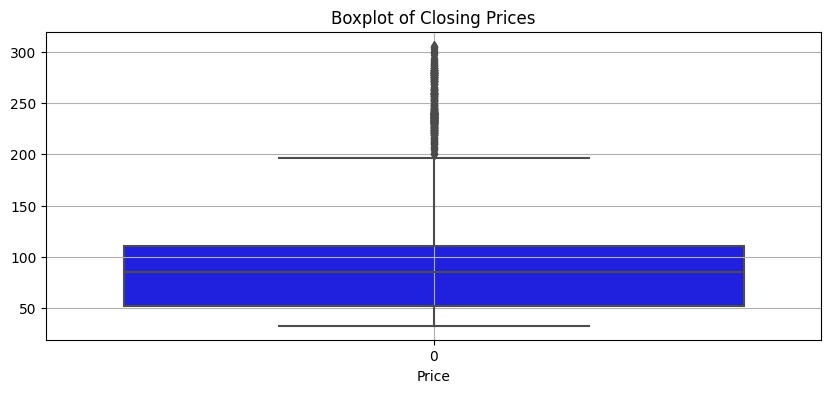

In [30]:
# Plot boxplot to identify outliers
plt.figure(figsize=(10, 4))
sns.boxplot(data['Close'], color='blue')
plt.title('Boxplot of Closing Prices')
plt.xlabel('Price')
plt.grid()
plt.show()

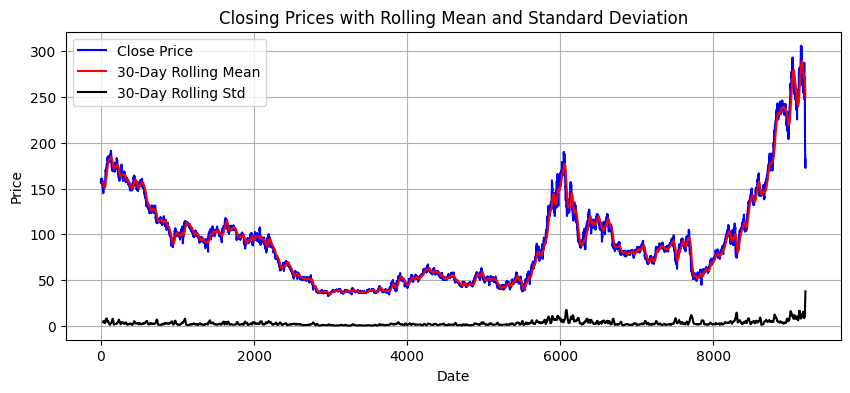

In [31]:
# Checking for seasonal trends using rolling mean
rolling_mean = data['Close'].rolling(window=30).mean()  # 30-day rolling mean
rolling_std = data['Close'].rolling(window=30).std()    # 30-day rolling std 



plt.figure(figsize=(10,4))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='red')
plt.plot(rolling_std, label='30-Day Rolling Std', color='black')
plt.title('Closing Prices with Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

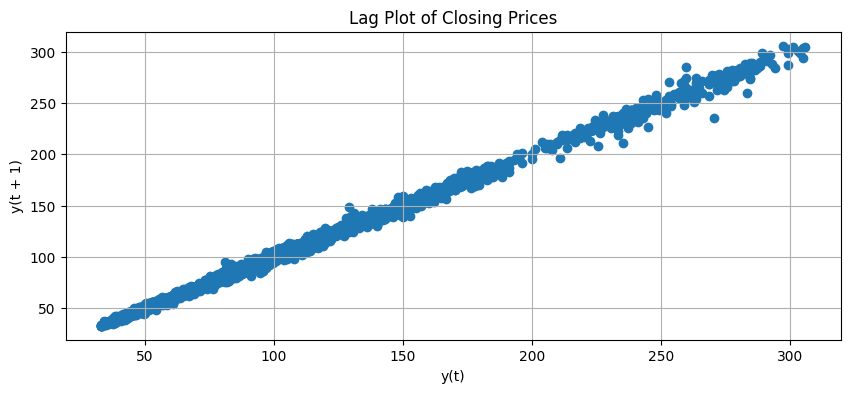

In [32]:
# Lag plot to check for autocorrelation
from pandas.plotting import lag_plot
plt.figure(figsize=(10, 4))
lag_plot(data['Close'])
plt.title('Lag Plot of Closing Prices')
plt.grid()
plt.show()

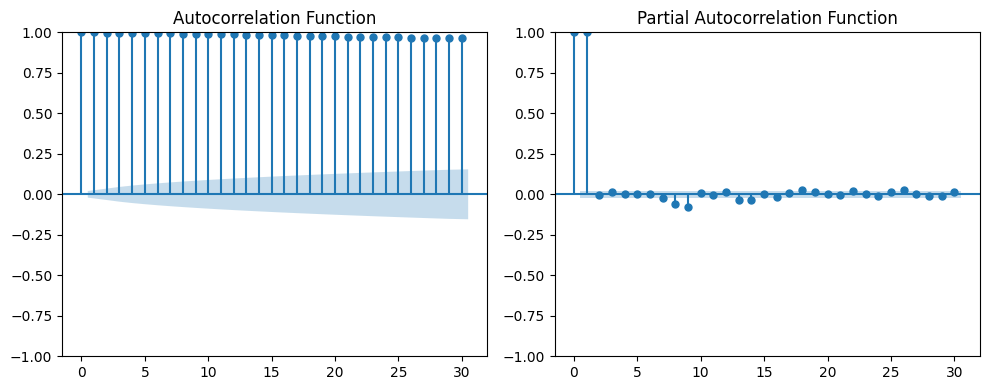

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,4))
plt.subplot(121)
plot_acf(data['Close'].dropna(), ax=plt.gca(), lags=30)
plt.title('Autocorrelation Function')
plt.subplot(122)
plot_pacf(data['Close'].dropna(), ax=plt.gca(), lags=30)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [36]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')

# Handle 'Change %' column if it is an object
if data['Change %'].dtype == 'object':
    data['Change %'] = data['Change %'].str.rstrip('%').astype('float') / 100.0
else:
    data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce') / 100.0

# Drop rows with NaN values in 'Change %' after conversion
data.dropna(subset=['Change %'], inplace=True)

# Handle 'Volume' column conversion
def convert_volume(volume):
    if isinstance(volume, str):
        if 'M' in volume:
            return float(volume.replace('M', '')) * 1e6
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1e9
        else:
            return float(volume.replace(',', ''))  # For numbers with commas
    return volume

data['Volume'] = data['Volume'].apply(convert_volume)

# Check for any remaining non-numeric values in 'Volume'
data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

# Drop rows with NaN values in 'Volume'
data.dropna(subset=['Volume'], inplace=True)

# Feature Engineering: Add technical indicators
data['MA10'] = data['Close'].rolling(window=10).mean()  # 10-day Moving Average
data['MA50'] = data['Close'].rolling(window=50).mean()  # 50-day Moving Average
data['EMA10'] = data['Close'].ewm(span=10, adjust=False).mean()  # 10-day Exponential Moving Average

# RSI calculation
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD calculation
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26  # MACD line

# Drop rows with NaN values
data.dropna(inplace=True)

# Prepare the feature set and target variable
X = data[['MA10', 'MA50', 'EMA10', 'RSI', 'MACD', 'Volume', 'Close']].values
y = data['Close'].values.reshape(-1, 1)

# Scaling the features and target variable
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create sequences for LSTM
def create_sequences(data, time_step=60):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_step):
        X_seq.append(data[i:(i + time_step)])
        y_seq.append(data[i + time_step, -1])  # Assuming the last feature is the target
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, time_step=60)

# Split data into training and test sets
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Build the improved LSTM model
model = Sequential()

# Add Bidirectional LSTM with Dropout
model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.3))

# Add a second LSTM layer
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Add a Dense layer with 25 units
model.add(Dense(25))

# Output layer
model.add(Dense(1))

# Compile the model using Adam optimizer with learning rate and MAE loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Callbacks: Early stopping, Model Checkpoint, Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # 100 
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    verbose=1
)

# Load the best model
model.load_weights('best_model.keras')

# Predict stock prices
predicted_stock_price = model.predict(X_test)

# Invert scaling for the predicted data
predicted_stock_price = scaler_y.inverse_transform(predicted_stock_price)

# Evaluate model performance (MAE)
mae = np.mean(np.abs(predicted_stock_price - scaler_y.inverse_transform(y_test.reshape(-1, 1))))
print(f'Mean Absolute Error: {mae}')

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - loss: 0.0454 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - loss: 0.0170 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - loss: 0.0138 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - loss: 0.0127 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - loss: 0.0120 - val_loss: 0.0066 - learning_rate: 5.0000e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - loss: 0.0116 - val_loss: 0.0069 - learning_rate: 5.0000e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - loss: 0.0109 - val_loss: 0.0101 - learning_rate: 5.0000e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - loss: 0.0110 - val_loss: 0.0063 - learning_rate: 5.0000e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - loss: 0.0105 - val_loss

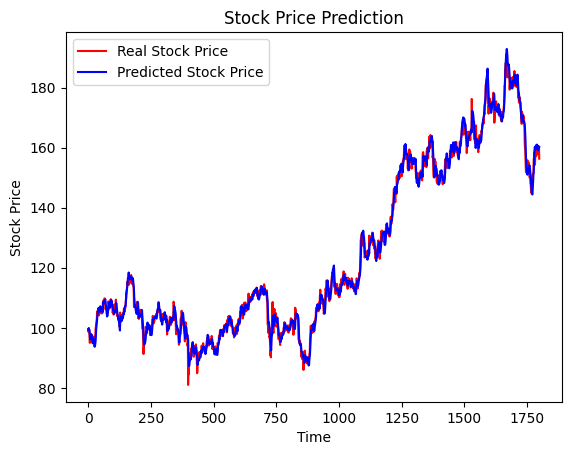

In [37]:
# Optionally, plot the results
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1, 1)), color='red', label='Real Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()